# Analisis exploratorio de los datos

In [3]:
import pandas as pd

df = pd.read_csv('/content/data_transactions.csv')

In [4]:
display(df.head())

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
0,user_51,recarga,19821.54,474314.99,494136.53,2023-01-01 00:00:00,0
1,user_92,recarga,5743.16,217815.04,223558.20,2023-01-01 00:01:00,0
2,user_14,retiro,17011.92,11710.15,-5301.77,2023-01-01 00:02:00,0
3,user_71,recarga,26655.67,469606.25,496261.92,2023-01-01 00:03:00,0
4,user_60,recarga,33147.40,16918.13,50065.53,2023-01-01 00:04:00,0


In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  object 
 1   transaction_type  10000 non-null  object 
 2   amount            10000 non-null  float64
 3   balance_before    10000 non-null  float64
 4   balance_after     10000 non-null  float64
 5   timestamp         10000 non-null  object 
 6   is_anomaly        10000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 547.0+ KB


None

In [8]:
display(df.describe())

,amount,balance_before,balance_after,is_anomaly
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000
mean,4.845413e+04,254697.230031,2.672200e+05,0.010400
std,3.154764e+05,141770.476819,3.483824e+05,0.101454
min,1.000000e+03,10008.200000,-4.621451e+06,0.000000
25%,1.168429e+04,130533.632500,1.365646e+05,0.000000
50%,1.818234e+04,254952.050000,2.628995e+05,0.000000
75%,2.474222e+04,377613.022500,3.852559e+05,0.000000
max,4.995116e+06,499986.350000,5.417279e+06,1.000000


# Primeros Hallazgos:
Hay un total de 10.001 filas y 7 columnas. No hay valores nulos

In [13]:
display(df['is_anomaly'].unique())

array([0, 1])

In [24]:
df['is_anomaly'].value_counts()

,count
is_anomaly,
0,9896
1,104


In [19]:
porcentaje_anomalos = (df['is_anomaly'].value_counts(normalize=True) * 100).round(2)

labels = porcentaje_anomalos.index.map(lambda x: f"Anomalía ({x})")

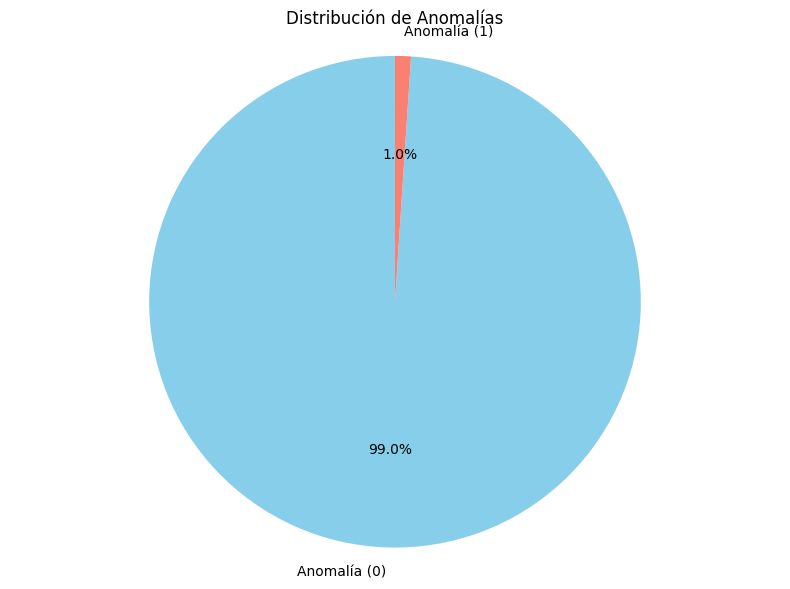

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Diagram de torta para visualizar el porcentaje de anomalias
plt.figure(figsize=(8, 6))
plt.pie(
    porcentaje_anomalos,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'salmon']
  )
plt.title('Distribución de Anomalías')
plt.axis('equal')  # Para que se vea redondo
plt.tight_layout()
plt.show()



# Segundos hallazgos clave

## Desbalance de Clases:
- El problema está **altamente desbalanceado**.
- Transacciones Normales (is_anomaly = 0): 9896 (99.0%)
- Transacciones Anómalas (is_anomaly = 1): 104 (1.0%)

Esto confirma que la precisión por sí sola sería una métrica engañosa.

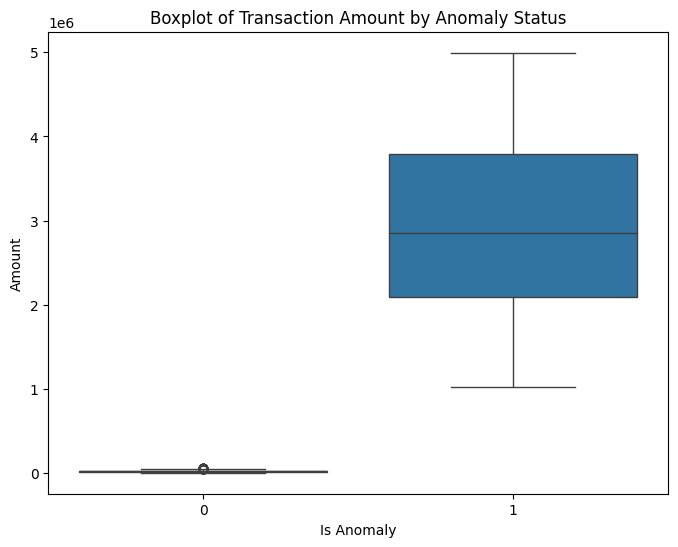

In [30]:
# Boxplot for 'amount'
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_anomaly', y='amount', data=df)
plt.title('Boxplot of Transaction Amount by Anomaly Status')
plt.xlabel('Is Anomaly')
plt.ylabel('Amount')
plt.show()

Las transacciones anomalas tienen montos mucho mas altos que los normales como se puede ver en el boxplot, el rango intercuartilico de las anomalías esta muy por encima de las transacciones normales

# Análisis temporales

A continuación se presentan algunas visualizaciónes temporales para su respectivo análisi, como resumen se presentan los días con mayor numero de anomalías que son del 2023/01/01 hasta 2023/01/07 y las horas en las que se presentan mas anomalías es a las 13:00 (1:00 pm)

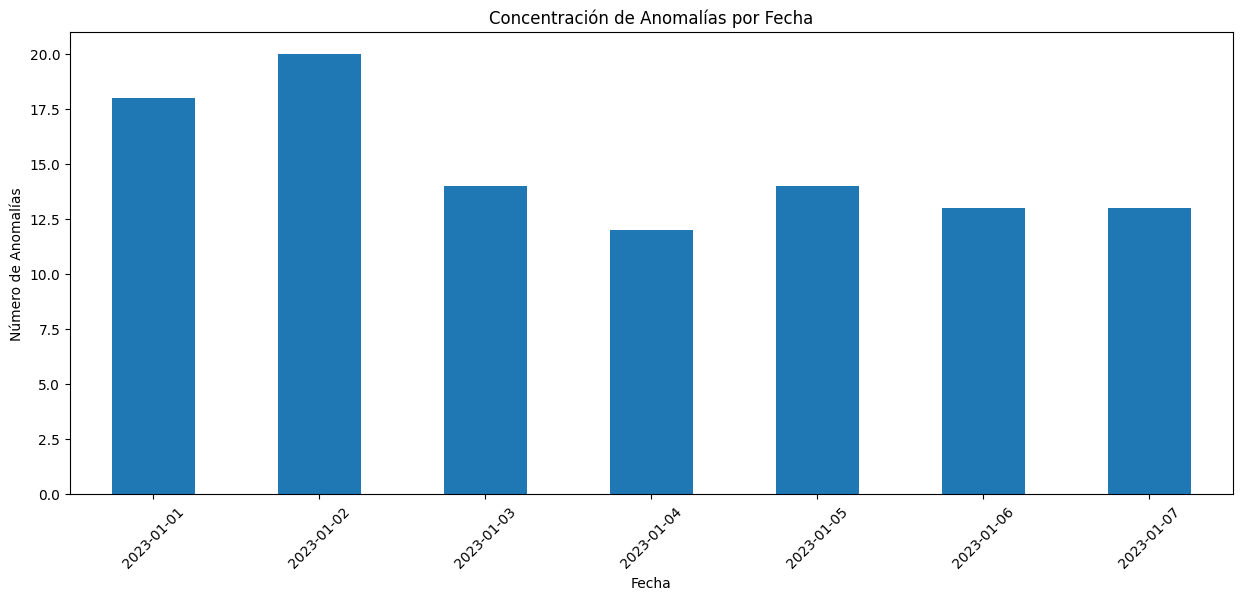

In [69]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

anomalies = df[df['is_anomaly'] == 1]

plt.figure(figsize=(15, 6))
anomalies['timestamp'].dt.date.value_counts().sort_index().plot(kind='bar')
plt.title('Concentración de Anomalías por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de Anomalías')
plt.xticks(rotation=45)
plt.show()

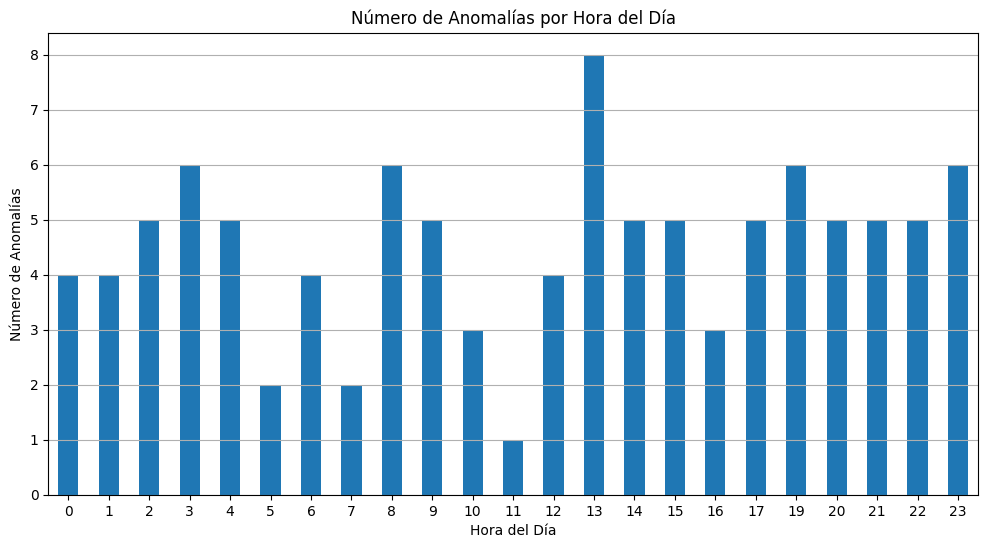

In [67]:
plt.figure(figsize=(12, 6))
anomalies['timestamp'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Número de Anomalías por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Anomalías')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

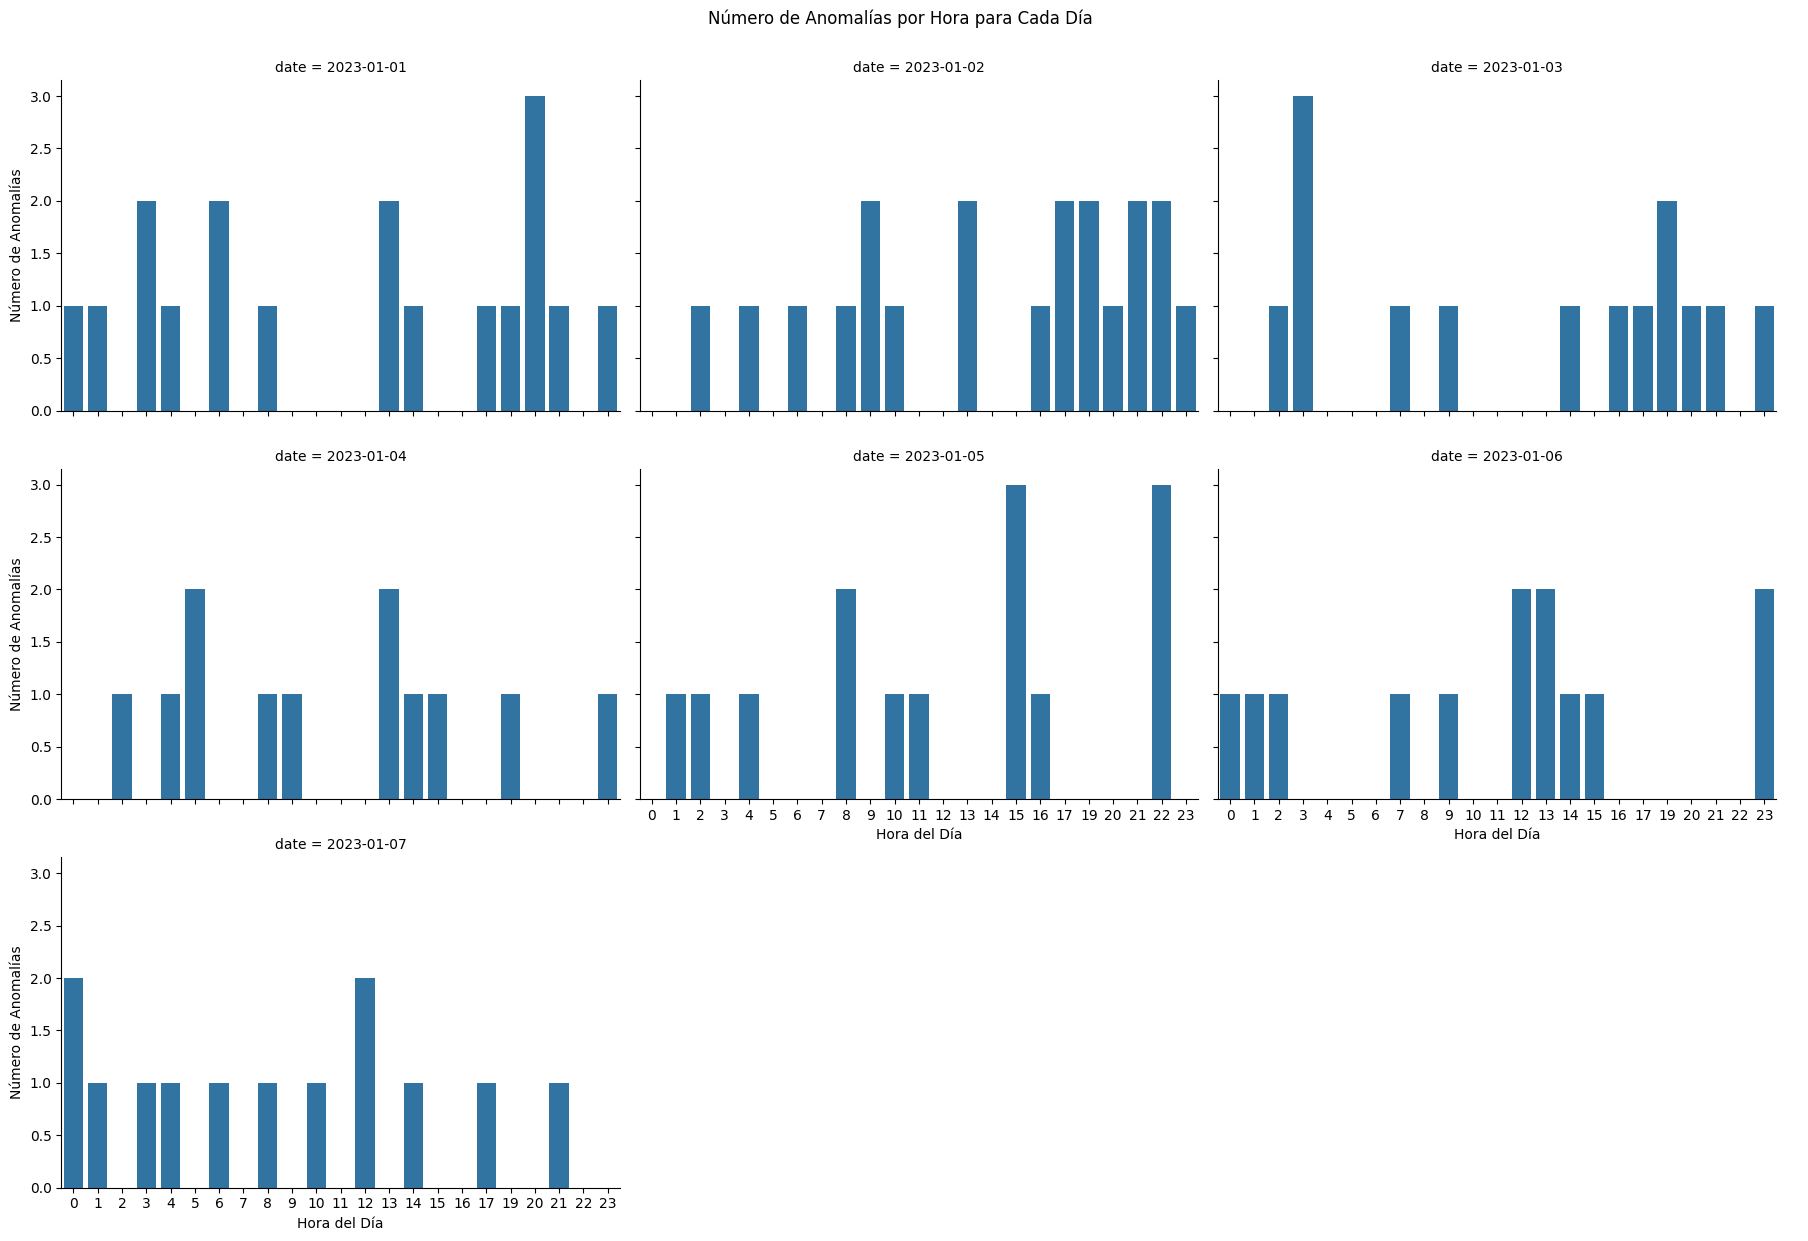

In [68]:
# Group by date and hour, and count anomalies
anomalies_by_hour = anomalies.groupby([anomalies['timestamp'].dt.date.rename('date'), anomalies['timestamp'].dt.hour.rename('hour')]).size().reset_index(name='count')

# Create a faceted bar chart
g = sns.catplot(x='hour', y='count', col='date', data=anomalies_by_hour, kind='bar', col_wrap=3, height=4, aspect=1.5)
g.fig.suptitle('Número de Anomalías por Hora para Cada Día', y=1.03)
g.set_axis_labels('Hora del Día', 'Número de Anomalías')
plt.show()